In [59]:
import pandas as pd
import numpy as np 
import matplotlib as mlp 
from matplotlib import pyplot as plt 
import geopandas as gp
import xlrd 
import os
import seaborn as sns

%matplotlib inline

In [ ]:
os.chdir("../../core")
import GT_helper_functions as hf
import GT_load_data as data

base_dir = "../../"

In [78]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200
sns.set_style("whitegrid")

In [5]:
def nextCell(row, offset = 0):
    lenr = len(row)
    if offset >= lenr:
        return None
    while (offset+1 < lenr) & (row[offset].ctype == xlrd.XL_CELL_EMPTY):
        offset += 1
    return offset

mapCodes = {
    2: "entidad",
    3: "ft_org_cor",
    5: "subprograma",
    6: "actividad_o",
    7: "renglon",
    9: "municipio"
}
codes = {
    "cod_entidad": None,
    "entidad": None,
    "cod_ft_org_cor": None,
    "ft_org_cor": None,
    "cod_subprograma": None,
    "subprograma": None,
    "cod_actividad_o": None,
    "actividad_o": None,
    "cod_renglon": None,
    "renglon": None,
    "cod_municipio": None,
    "municipio": None
}
cols = list(codes.keys())
cols.extend([
    "ASIGNADO", "MODIFICADO", "VIGENTE", "PRE_COMPROMISO", 
    "COMPROMETIDO", "DEVENGADO", "PAGADO", "SALDO_POR_COMPROMETER", 
    "SALDO_POR_DEVENGAR", "SALDO_POR_PAGAR", "PorcentajeEJEC"
    ])
len(cols)

23

In [ ]:
list.extend()

In [6]:
def SICOIN_extractTable(xlsName):
    xlsfile = xlrd.open_workbook(xlsName)
    sheet = xlsfile.sheet_by_index(0)
    year = sheet.cell_value(rowx = 14, colx = 10)
    i = 19
    data = []
    continuousEmpty = 0
    while True:
        i += 1
        if i >= sheet.nrows:
            break
        row = sheet.row(i)
        j = 0
        j = nextCell(row, j)
        j0 = j
        if j <= 9:
            continuousEmpty = 0

            code = str(row[j].value).strip()
            if code == "TOTAL":
                continue

            j = nextCell(row, j+1)
            name = str(row[j].value).strip()
            
            cod_index = mapCodes[j0]
            if (j0 in [5,6]):
                if (len(code) == 5):
                    cod_index = "subprograma"
                else:
                    cod_index = "actividad_o"

            codes[cod_index] = name
            codes["cod_" + cod_index] = code

            j = nextCell(row, j+1)
            if j is None:
                continue
            if j == 63: 
                continue

            rowData = list(codes.values())
            while True:
                value = str(row[j].value).strip()
                rowData.append(value)
                j = nextCell(row, j+1)
                if j is None:
                    break

            data.append(rowData)
        elif j == 63:
            # empty row
            continuousEmpty += 1
        if continuousEmpty > 5:
            break;
    df = pd.DataFrame(data = data, columns = cols)
    df["Year"] = year
    return df

In [15]:
dataset = None

for root, dirs, files in os.walk("../../Resource Tracking/SICOIN GT/Raw Data/"):
    n = len(files)
    for file in files:
        if file.endswith(".xls"):
            temp = SICOIN_extractTable(root + file)
            n -= 1
            print("Extracted ", file, " with nrows = ", len(temp), ". ", n, " remain.")
            if dataset is None:
                dataset = temp
            else:
                dataset = pd.concat([dataset, temp])

Extracted  SICOIN - MSPAS VectoresZoontca - FR-ORG-COR SubP ActivOb Renglon Muni - 2017.xls  with nrows =  3625 .  26  remain.
Extracted  SICOIN - MSPAS TB FR-ORG-COR SubP ActivOb Renglon Muni - 2015.xls  with nrows =  2098 .  25  remain.
Extracted  SICOIN - MSPAS VectoresZoontca - FR-ORG-COR SubP ActivOb Renglon Muni - 2013.xls  with nrows =  3395 .  24  remain.
Extracted  SICOIN - MSPAS VectoresZoontca - FR-ORG-COR SubP ActivOb Renglon Muni - 2018.xls  with nrows =  3932 .  23  remain.
Extracted  SICOIN - MSPAS VectoresZoontca - FR-ORG-COR SubP ActivOb Renglon Muni - 2016.xls  with nrows =  3904 .  22  remain.
Extracted  SICOIN - MSPAS VIH FR-ORG-COR SubP ActivOb Renglon Muni - 2016.xls  with nrows =  2246 .  21  remain.
Extracted  SICOIN - MSPAS VectoresZoontca - FR-ORG-COR SubP ActivOb Renglon Muni - 2015.xls  with nrows =  4229 .  20  remain.
Extracted  SICOIN - MSPAS VIH FR-ORG-COR SubP ActivOb Renglon Muni - 2013.xls  with nrows =  1615 .  19  remain.
Extracted  SICOIN - MSPAS V

In [100]:
donantes = {
    "401": "BCIE",
    "402": "BID",
    "403": "BIRF", # Banco Internacional de Reconstruccion y Fomento
    "409": "Comun. Econ. Europea",
    "418": "ONU Infancia",
    "421": "WHO",
    "423": "FONDO DE POBLACION ONU",
    "425": "Global Fund",
    "555": "AGENCIA DE COOPERACION INTERNACIONAL DE COREA",
    "2102": "Other External Donors"
}
dkeys = donantes.keys()
dvals = donantes.values()
 
def sourceGen(inputstr):
    if inputstr.startswith("61"):
        for key, val in donantes.items():
            if key in inputstr:
                return val
        return "Unknown Donor"
    return "GHE"

dataset["Source"] = dataset.cod_ft_org_cor.map(sourceGen)
dataset.Source.value_counts()

GHE                      47372
Global Fund               1260
Other External Donors      221
Unknown Donor               28
BID                          9
Comun. Econ. Europea         1
Name: Source, dtype: int64

In [46]:
dataset["DEVENGADO"] = dataset.DEVENGADO.astype(float)

def diseaseGen(row):
    if row.Year >= 2013:
        if row.cod_subprograma[0:2] == "17":
            return "TB"
        if row.cod_subprograma[0:2] == "16":
            return "VIH"
        if (row.cod_subprograma[0:2] == "18") & ("malaria" in row.actividad_o.lower()):
            return "Malaria"
    elif row.Year == 2012:
        if row.cod_actividad_o == "12 01 000 005 000":
            return "TB"
        if row.cod_actividad_o == "12 01 000 004 000":
            return "VIH"
        if (row.cod_actividad_o == "12 01 000 008 000") | (row.cod_actividad_o == "14 02 000 002 000"):
            return "Malaria"
    elif row.Year == 2011:
        if row.cod_actividad_o == "12 01 000 005 000":
            return "TB"
        if row.cod_actividad_o == "12 01 000 008 000":
            return "VIH"
        if row.cod_actividad_o == "12 02 000 003 000":
            return "Malaria"
    
dataset["disease"] = dataset.apply(diseaseGen, 1)
#.groupby(["ft_org_cor"]).DEVENGADO.sum()

In [196]:
(dataset.groupby(["Source", "Year"]).DEVENGADO.sum().unstack(1) / 1000000).round(2)

Year,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
Source,,,,,,,,
BID,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN
Comun. Econ. Europea,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GHE,49.84,102.75,134.66,209.67,196.90,230.87,261.96,248.89
Global Fund,4.66,31.63,31.41,35.09,35.98,14.32,11.96,14.25
Other External Donors,0.02,6.04,3.13,4.70,0.81,0.00,0.00,0.00
Unknown Donor,NaN,NaN,0.51,0.00,NaN,NaN,NaN,NaN


In [185]:
(dataset.groupby(["disease", "Source", "Year"]).DEVENGADO.sum().unstack(1) / 1000000).round(2)\
        #.assign(gfp = lambda x: x.GF.divide(x.sum(1), 1).round(2)*100 ).fillna(0)

Source          BID  Comun. Econ. Europea    GHE  Global Fund  \
disease Year                                                    
Malaria 2011.0  NaN                   NaN   0.08         0.96   
        2012.0  0.0                   NaN  58.45        23.63   
        2013.0  0.0                   NaN   9.11        22.45   
        2014.0  NaN                   NaN  18.08        17.15   
        2015.0  NaN                   NaN  17.14        22.34   
        2016.0  NaN                   NaN  22.46         6.70   
        2017.0  NaN                   NaN  24.81         6.71   
        2018.0  NaN                   NaN  26.26         8.34   
TB      2011.0  NaN                   NaN   0.49          NaN   
        2012.0  NaN                   NaN   1.79          NaN   
        2013.0  NaN                   NaN   9.70          NaN   
        2014.0  NaN                   NaN   8.17          NaN   
        2015.0  NaN                   NaN  18.31          NaN   
        2016.0  NaN                   NaN  14.12         0.70   
        2017.0  NaN                   NaN  12.99         2.69   
        2018.0  NaN                   NaN  13.84         5.17   
VIH     2011.0  0.0                   0.0  49.27         3.70   
        2012.0  NaN                   NaN  40.11         8.00   
        2013.0  NaN                   NaN  49.49         8.97   
        2014.0  NaN                   NaN  87.13        17.94   
        2015.0  NaN                   NaN  62.80        13.64   
        2016.0  NaN                   NaN  78.53         6.92   
        2017.0  NaN                   NaN  97.18         2.56   
        2018.0  NaN                   NaN  88.89         0.74   

Source          Other External Donors  Unknown Donor  
disease Year                                          
Malaria 2011.0                    NaN            NaN  
        2012.0                    NaN            NaN  
        2013.0                    NaN           0.00  
        2014.0                    NaN           0.00  
        2015.0                    NaN            NaN  
        2016.0                    NaN            NaN  
        2017.0                    NaN            NaN  
        2018.0                    NaN            NaN  
TB      2011.0                   0.02            NaN  
        2012.0                   6.04            NaN  
        2013.0                   3.13            NaN  
        2014.0                   4.70            NaN  
        2015.0                   0.81            NaN  
        2016.0                   0.00            NaN  
        2017.0                   0.00            NaN  
        2018.0                   0.00            NaN  
VIH     2011.0                    NaN            NaN  
        2012.0                    NaN            NaN  
        2013.0                    NaN           0.51  
        2014.0                    NaN           0.00  
        2015.0                    NaN            NaN  
        2016.0                    NaN            NaN  
        2017.0                    NaN            NaN  
        2018.0                    NaN            NaN

In [186]:
13.64+22.34

35.980000000000004

In [27]:
dataset.to_csv("../../Resource Tracking/SICOIN GT/SICOIN 2011-2018.csv")

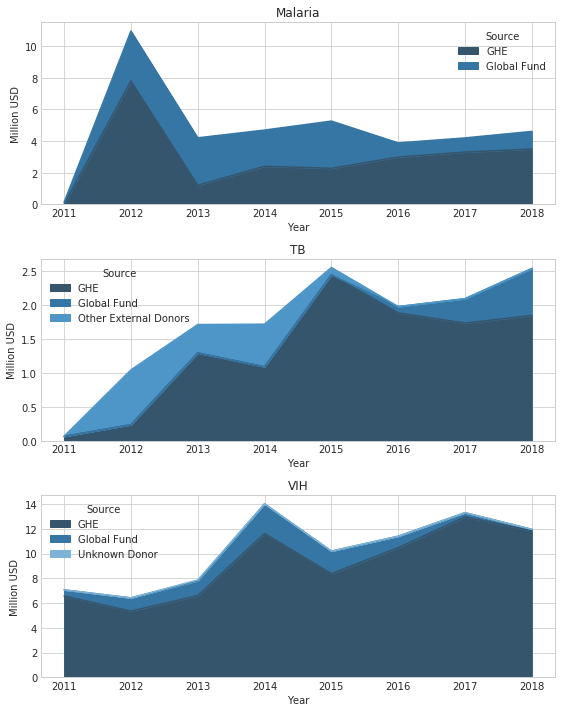

In [144]:
mlp.rcParams['figure.figsize'] = [8, 10]

levels = temp.columns.get_level_values(1).unique()
pal = sns.color_palette("Blues_d", n_colors = len(levels), )
levelsColors = dict(zip(levels, pal))

temp = dataset.sort_values("Source").groupby(["Year", "disease", "Source"])\
    .DEVENGADO.sum()[lambda x: x>0].unstack([1, 2]).divide(7.5*1000000).sort_index(axis="columns").fillna(0)

for i,disease in zip(range(1,4), ["Malaria", "TB", "VIH"]):
    ax = plt.subplot(3,1,i)
    temp[(disease)].plot.area(ax = ax, color = [levelsColors[x] for x in temp[(disease)].columns.values])
    ax.set_title(disease)
    ax.set_ylabel("Million USD")

plt.tight_layout()

In [140]:
temp

disease   Malaria                    TB                                    \
Source        GHE Global Fund       GHE Global Fund Other External Donors   
Year                                                                        
2011.0   0.010243    0.127829  0.065841    0.000000              0.002667   
2012.0   7.793682    3.151094  0.238418    0.000000              0.805281   
2013.0   1.214512    2.993090  1.293401    0.000000              0.417394   
2014.0   2.410333    2.286903  1.089745    0.000000              0.626731   
2015.0   2.285561    2.978335  2.441532    0.000000              0.108432   
2016.0   2.994956    0.892900  1.882242    0.092800              0.000000   
2017.0   3.307505    0.895250  1.732057    0.358732              0.000000   
2018.0   3.501634    1.111383  1.845453    0.689210              0.000000   

disease        VIH                            
Source         GHE Global Fund Unknown Donor  
Year                                          
2011.0    6.569896    0.493611      0.000000  
2012.0    5.348477    1.066509      0.000000  
2013.0    6.598515    1.195377      0.067891  
2014.0   11.617407    2.392053      0.000000  
2015.0    8.373654    1.819218      0.000000  
2016.0   10.471307    0.923273      0.000000  
2017.0   12.956982    0.340939      0.000000  
2018.0   11.852046    0.098997      0.000000

In [180]:
renglonesTop10Malaria =  (dataset[(dataset.disease == "Malaria") & (dataset.Source.isin(["GHE", "Global Fund"]))].groupby(["Year", "renglon", "Source"])\
     .DEVENGADO.sum()/1e6).reset_index().groupby(["Source", "Year"])\
    .apply(lambda x: x.sort_values("DEVENGADO", ascending=False)[["renglon", "DEVENGADO"]].head(10).round(1))

In [187]:
dataset.cod_actividad_o.value_counts()

18 00 000 002 000    9657
18 00 000 001 000    7526
16 00 000 002 000    6244
17 00 000 002 000    5624
17 00 000 001 000    5296
16 00 000 001 000    4277
18 00 000 003 000    3159
18 00 000 004 000    2897
16 00 000 003 000    1697
16 00 000 004 000     920
12 01 000 008 000     866
14 02 000 002 000     247
16 00 000 005 000     217
12 01 000 004 000     110
12 02 000 003 000      82
12 01 000 005 000      67
12 02 000 008 000       5
Name: cod_actividad_o, dtype: int64

In [195]:
(dataset.cod_renglon + dataset.renglon).value_counts().head()

295UTILES MENORES MEDICO-QUIRURGICOS Y DE LAB.    4672
266PRODUCTOS MEDICINALES Y FARMACEUTICOS          4019
291UTILES DE OFICINA                              3669
261ELEMENTOS Y COMPUESTOS QUIMICOS                2644
262COMBUSTIBLES Y LUBRICANTES                     2468
dtype: int64

In [194]:
dataset[(dataset.cod_renglon == "266") & (dataset.cod_subprograma == "16 00") & 
        (dataset.Year == 2014)].head(2) # .DEVENGADO.sum()

,cod_entidad,entidad,cod_ft_org_cor,ft_org_cor,cod_subprograma,subprograma,cod_actividad_o,actividad_o,cod_renglon,renglon,cod_municipio,municipio,ASIGNADO,MODIFICADO,VIGENTE,PRE_COMPROMISO,COMPROMETIDO,DEVENGADO,PAGADO,SALDO_POR_COMPROMETER,SALDO_POR_DEVENGAR,SALDO_POR_PAGAR,PorcentajeEJEC,Year,finsource,disease,Source
325,11130009,MINISTERIO DE SALUD PÚBLICA Y ASISTENCIA SOCIAL,11 0000 000,INGRESOS CORRIENTES,16 00,SIN SUBPROGRAMA,16 00 000 001 000,"PREVENCIÓN DE ITS, VIH/SIDA",266,PRODUCTOS MEDICINALES Y FARMACEUTICOS,0101,GUATEMALA,7815734.0,14362359.44,22178093.44,76848.0,18159153.97,18159153.97,17497563.35,4018939.47,4018939.47,661590.62,81.87878736793706,2014.0,GHE,VIH,GHE
326,11130009,MINISTERIO DE SALUD PÚBLICA Y ASISTENCIA SOCIAL,11 0000 000,INGRESOS CORRIENTES,16 00,SIN SUBPROGRAMA,16 00 000 001 000,"PREVENCIÓN DE ITS, VIH/SIDA",266,PRODUCTOS MEDICINALES Y FARMACEUTICOS,0103,SAN JOSE PINULA,6250.0,-6250.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,2014.0,GHE,VIH,GHE
